In [3]:
# Imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import Input, Model, Sequential
from keras.layers import LSTM, Embedding, Dense, Concatenate, TimeDistributed, Dropout, Bidirectional, SpatialDropout1D
import tensorflow as tf

In [4]:
def read_data():
    os.chdir('D:/TU_Graz/Thesis/Datasets/Reddit_features')

    train = pd.read_csv("train_final_all.csv")
    test = pd.read_csv("test_final_all.csv")
    data = train.append(test)
    return train, test, data

In [5]:
def create_lists(data, category):
    words = list(set(data["Token"].values))
    words.append("ENDPAD")
    n_words = len(words)
    tags = list(set(data[category].values))
    n_tags = len(tags)
    
    return words, n_words, tags, n_tags

In [6]:
def group_sentences(data, category):
    all_sents = []
    sent_ids = data['Sent_id'].unique()
    for curr_id in sent_ids:
        tmp_df = data[data['Sent_id'] == curr_id]
        tmp_df = pd.concat([tmp_df['Token'], tmp_df["Token_index"], tmp_df.iloc[:,4:147], tmp_df[category]], axis = 1)
        records = tmp_df.to_records(index=False)
        all_sents.append(records)
    return all_sents

In [7]:
def remove_sents_over_threshold(sents, threshold):
    sentences = list()
    for s in sents:
        if len(s) < threshold:
            sentences.append(s)
    return sentences

In [8]:
def prepare_and_pad(sentences, max_len, word2idx, tag2idx):
    X1 = [[word2idx[w[0]] for w in s] for s in sentences]
    X1 = pad_sequences(maxlen = max_len, sequences = X1, padding = "post", value = n_words - 1)
    X2 = []
    for sentence in sentences:
        sent_ft = list()
        for word in sentence:
            ft = list()
            for i in range(1, 144):
                ft.append(word[i])
            sent_ft.append(ft)
        for j in range(len(sentence)-1, max_len-1):
            ft = list()
            for i in range(1, 144):
                ft.append(word2idx['ENDPAD'])
            sent_ft.append(ft)
        X2.append(sent_ft)  

    y = [[tag2idx[w[len(w)-1]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=n_tags) for i in y]
    
    return X1, X2, y

In [9]:
def build_model(max_len, n_words, n_tags):
    input_1 = Input(shape=(max_len,))
    emb = Embedding(input_dim=n_words, output_dim=300, input_length=max_len)(input_1)
    
    input_2 = Input(shape=(max_len, 143, ))
    fts = Dense(n_tags, activation = 'softmax')(input_2)
    
    model = Concatenate()([emb, fts])
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.2))(model)  # variational biLSTM
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(model) 
    model = Model([input_1, input_2], out)
    
    return model 

In [10]:
def plot_learning_curves(hist, curve1, curve2):
    plt.figure(figsize=(6,6))
    plt.plot(hist[curve1])
    plt.plot(hist[curve2])
    plt.show()

In [11]:
def test_data(X1_te, X2_te, y_te):
    y_pred = model.predict([X1_te, np.array(X2_te).reshape((len(X2_te), max_len, 143))])
    p = np.argmax(y_pred, axis=-1)
    y_te = np.array(y_te)
    y_te = np.argmax(y_te, axis=-1)

    y_orig = []
    for sent in y_te:
        for tag in sent:
            y_orig.append(tag)
    y_preds = []
    for sent in p:
        for tag in sent:
            y_preds.append(tag)    
        
    report = classification_report(y_orig, y_preds)
    print(report)   

Reading the data...
Creating sets of words and tags...
Creating sentence list...
Removing submissions longer than threshold...
Creating word and tag maps...
Padding data...
Building the model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300, 143)]   0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     2922900     ['input_1[0][0]']                
                                                                                                 

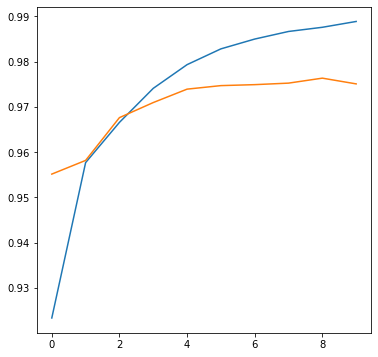

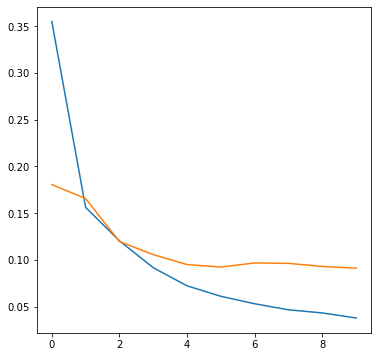

Test the model...
12/12 [==============================] - 35s 3s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.92      0.76      0.83        46
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        28
           7       0.84      0.78      0.81      1409
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        32
          10       0.99      0.99      0.99    104277
          11       0.72      0.74      0.73       214
          12       0.00      0.00      0.00         4
          13       0.80      0.83      0.82      1814
          14       0.44      0.39      0.41       750
          15       0.00      0.00      0.00        37
          16       0.23      0.34      0.27       456

    accur

C:\Users\Kiki\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print("Reading the data...")
train, test, data = read_data()

print("Creating sets of words and tags...")
words, n_words, tags, n_tags = create_lists(data, "BIO")

print("Creating sentence list...")
sents = group_sentences(data, 'BIO')

print("Removing submissions longer than threshold...")
sentences = remove_sents_over_threshold(sents, 300)

print("Creating word and tag maps...")
max_len = 300
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print("Padding data...")
X1, X2, y = prepare_and_pad(sentences, max_len, word2idx, tag2idx)

# Train and test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.25, shuffle=False)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.25, shuffle=False)
y_test = y1_test
y_train = y1_train

print("Building the model...")
model = build_model(max_len, n_words, n_tags)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

print("Fitting the model....")
history = model.fit([X1_train, np.array(X2_train).reshape((len(X2_train), max_len, 143))], 
                    np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1)
hist = pd.DataFrame(history.history)

print("Plotting learning curves...")
plot_learning_curves(hist, "accuracy", "val_accuracy")
plot_learning_curves(hist, "loss", "val_loss")

print("Test the model...")
test_data(X1_test, X2_test, y_test)